In [1]:
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import anndata

/home/hanlitian/miniconda3/envs/py3/lib/python3.9/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
import os
from sys import argv
from pathlib import Path

import numpy as np
import pandas as pd
import time as tm
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [127]:
from sklearn.ensemble import RandomForestClassifier

In [4]:
adata=sc.read("../../important_processed_data/5.22_integrate_adata.h5ad")

In [5]:
micro=sc.read("../data/tabula/MCA_BatchRemoved_Merge_dge.h5ad")

In [6]:
microMeta=pd.read_csv("../data/tabula/MCA_BatchRemoved_Merge_dge_cellinfo (1).csv",index_col=1)

In [7]:
microMeta

,Unnamed: 0,louvain,tissue,stage
index,,,,
AdultBladder_1.CCATCTAGCGAGTTTAGG,1,83,AdultBladder,Adult
AdultBladder_1.GAGGAGCGCTTGATACAG,2,83,AdultBladder,Adult
AdultBladder_1.CCAGACACAATAGAATTA,3,83,AdultBladder,Adult
AdultBladder_1.CCGACGGGACATATGGCG,4,83,AdultBladder,Adult
AdultBladder_1.TAGCATTCAAAGATTCCA,5,83,AdultBladder,Adult
...,...,...,...,...
Uterus_2.TTTAGGCCGACGGGACAT,333774,48,AdultUterus,Adult
Uterus_2.TTTAGGTGCAATGAATTA,333775,40,AdultUterus,Adult
Uterus_2.AAAGTTACCTGAATGGCG,333776,45,AdultUterus,Adult


In [8]:
micro.obs=microMeta

In [9]:
sc.pp.subsample(micro,fraction=0.2)

In [10]:
adata_sub= adata[:, adata.var["highly_variable"]]

In [11]:
adata.var["highly_variable"]

00R-AC107638.2    False
0610005C13Rik     False
0610005C13rik     False
0610006L08Rik     False
0610007N19Rik     False
                  ...  
tg-beta-lac       False
tg-tdTom          False
tomato            False
uc-338            False
z                 False
Name: highly_variable, Length: 62934, dtype: bool

In [12]:
adata_sub.X=adata_sub.layers["counts"]

In [13]:
adata_concat=anndata.concat([adata_sub,micro],join='outer')

/home/hanlitian/miniconda3/envs/py3/lib/python3.9/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [14]:
adata_concat

AnnData object with n_obs × n_vars = 339124 × 34957
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'Sample', 'Project', 'Limb.Atlas', 'Organ', 'Tissue', 'Tissue.Specific.', 'Stage', 'Gene.type', 'Treatment', 'Age', 'Age.In.Detail.', 'Machine', 'Species', 'Isolation.approach', 'Digestion', 'Enzymes', 'Bone.Forming.Methods', 'Data.Source', 'Related.Assay', 'Origin', 'nCount_RNA', 'nFeature_RNA', 'paper_label', 'coarse_label', 'scDblFinder_class', 'short_id', 'temp_cluster', 'batch', 'batch_atlas', 'size_factors', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'new_totals_log', 'anno_level_1', 'anno_level_2', 'anno_level_3', 'anno_level_4', 'anno_level_5', 'mix_level_1', 'mix_level_2', 'merge_id_level3', 'merge_id_level4', 'merge_id_level5', 'cellid', 'leiden_clusters_level_1', 'leiden_clusters_level_2', 'le

In [15]:
adata_concat=adata_concat[:, adata_sub.var_names]

In [16]:
mesLineage=pd.read_csv("../../important_processed_data/6.25_lineageMeta.csv",index_col=0)

In [17]:
mesLineage["mes_merge"]=mesLineage["lineage_laFibro"] | mesLineage["lineage_mesenchyme"]

In [18]:
merged_df = pd.merge(adata_concat.obs, mesLineage, left_index=True, right_index=True,how="left")

In [19]:
merged_df["mes_merge"]=merged_df["mes_merge"].fillna(False)

In [20]:
merged_df["lineage_lepr"]=merged_df["lineage_lepr"].fillna(False)

In [21]:
merged_df["lineage_chondro"]=merged_df["lineage_chondro"].fillna(False)

In [22]:
adata_concat.obs=merged_df

In [23]:
Classifier = LinearSVC()
clf = CalibratedClassifierCV(Classifier)

In [26]:
dataDf=adata_concat.X.toarray()

In [29]:
mesLabel=adata_concat.obs["mes_merge"]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
     dataDf, mesLabel, test_size=0.4, random_state=0)

In [95]:
y_train

TCAAGACGTTCAAGTC-1_5-1-2                                   False
AGACCCGGTGTTCCAA-1_3-1-2                                   False
BmscTime_Zhong_1.5M_TGAGCCGGTACTCGCG_2-0-2                 False
PeripheralBlood_6.CCGCTAATGCTTTAGAGA                       False
BmscTime_Zhong_16M_ATTCTTGGTTAGGGAC_4-0-2                  False
                                                           ...  
LimbMouse2019_Kelly_E13_CAGCTAAAGCCGTCGT-1_2-1             False
MammaryGland.Lactation_2.CATCCCCCAGACCCTTTC                False
Bmsc2019_Regev_samp1_baryawno:std1_CTTGGCTCATATGAGA-0-2    False
LimbG610C_Gorrell_femurWT4_AGACCCGCATAACGGG-1_7-1          False
Thymus_1.AAAACGCGAGTATCACTT                                False
Name: mes_merge, Length: 203474, dtype: bool

In [96]:
start=tm.time()
clf.fit(X_train, y_train)
tr_time.append(tm.time()-start)


/home/hanlitian/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hanlitian/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hanlitian/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hanlitian/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hanlitian/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


NameError: name 'tr_time' is not defined

In [98]:
predicted = clf.predict(X_test)

In [99]:
predicted

array([False, False, False, ...,  True, False, False])

In [100]:
prob = np.max(clf.predict_proba(X_test), axis = 1)

In [106]:
trueNum=sum(predicted==y_test)

In [105]:
len(y_test)

135650

In [109]:
rateLVM=trueNum/len(y_test)

In [111]:
y_test.to_csv("../result/6.24_lineage_predict/svm_truelab.csv",
                   index = False)

In [113]:
pd.DataFrame(predicted).to_csv("../result/6.24_lineage_predict/svm_predict.csv",
                index = False)

In [115]:
import joblib
joblib.dump(clf, "../result/6.24_lineage_predict/svm.joblib")

['../result/6.24_lineage_predict/svm.joblib']

In [24]:
import celltypist

2023-06-26 14:11:41.963079: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-26 14:11:42.304158: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-26 14:11:42.305826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 14:11:43.601171: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [126]:
#sc.pp.normalize_total(adata_concat, target_sum = 1e4)
#sc.pp.log1p(adata_concat)

In [31]:
adata_train=adata_concat[y_train.index,:]

In [32]:
adata_test=adata_concat[y_test.index,:]

In [33]:
sc.pp.normalize_total(adata_train, target_sum = 1e4)
sc.pp.log1p(adata_train)

In [34]:
sc.pp.normalize_total(adata_test, target_sum = 9999)
sc.pp.log1p(adata_test)

In [179]:
adata_test.X[1:10,1:10].toarray()

array([[0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 8.       , 0.       , 0.       ,
        0.       , 0.       , 0.       ],
       [0.       , 0.       , 3.       , 0.       , 0.       , 0.       ,
        2.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        1.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        1.       , 0.       , 1.       ],
       [0.       , 3.       , 0.       , 0.       , 1.       , 0.       ,
        0.       , 0.       , 0.       ],
       [0.       , 2.       , 1.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.8743968, 0.       , 0.8743968],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       

In [35]:
import time
t_start = time.time()
model_fs = celltypist.train(adata_train, 'mes_merge', n_jobs = 20, max_iter = 100, use_SGD = True)
t_end = time.time()

🍳 Preparing data before training
🔬 Input data has 203474 cells and 2000 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
✅ Model training done!


In [36]:
t_end-t_start

111.09527683258057

In [134]:
model_fs.write('../result/6.26_celltypist_mes.pkl')

In [37]:
t_start = time.time()
predictions = celltypist.annotate(adata_test, model = model_fs)
t_end = time.time()
print(f"Time elapsed: {t_end - t_start} seconds")

🔬 Input data has 135650 cells and 2000 genes
🔗 Matching reference genes in the model
🧬 2000 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


Time elapsed: 4.460107088088989 seconds


In [50]:
predictions.predicted_labels["predicted_labels"].values

[False, False, False, True, False, ..., False, False, True, False, False]
Length: 135650
Categories (2, object): [False, True]

In [53]:
predictions_adata = predictions.to_adata()

In [51]:
sum(predictions.predicted_labels["predicted_labels"].values==y_test)

127948

In [55]:
predictions_adata.write_h5ad('../result/6.24_lineage_predict/celltyplist.h5ad')

... storing 'cellid' as categorical
... storing 'tissue' as categorical
... storing 'stage' as categorical


TypeError: Can't implicitly convert non-string objects to strings

Above error raised while writing key 'Limb.Atlas' of <class 'h5py._hl.group.Group'> to /

In [62]:
predictions_adata.obs

,orig.ident,nCount_originalexp,nFeature_originalexp,Sample,Project,Limb.Atlas,Organ,Tissue,Tissue.Specific.,Stage,...,louvain,tissue,stage,lineage_chondro,lineage_laFibro,lineage_lepr,lineage_mesenchyme,mes_merge,predicted_labels,conf_score
Frontal_Holmes_WTE18.5_3_GCTCAAAAGGTCGACA_11-0,Frontal_Holmes_WTE18.5_3,3407.39713,5428.0,Frontal_Holmes_WTE18.5_3,Frontal_Holmes,False,Head,Suture mesenchyme,Frontal suture,Development,...,NaN,NaN,NaN,False,False,False,False,False,False,1.0
AdultBladder_1.TTCCGCTAGAGAGGGCGA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,83.0,AdultBladder,Adult,False,NaN,False,NaN,False,False,1.0
Testis_1.CCGCTAAATAAATGCAAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.0,AdultTestis,Adult,False,NaN,False,NaN,False,False,1.0
sagittal_Holmes_E18_AGCATACTCCGTAGGC-1-0,sagittal_Holmes_E18,8314.00000,2196.0,sagittal_Holmes_E18,sagittal_Holmes,False,Head,Suture mesenchyme,Sagittal suture,Development,...,NaN,NaN,NaN,False,False,False,True,True,True,1.0
BmscSpecification_Kishor_3_TACGGATCACGAAACG_3-0-2,BmscSpecification_Kishor_3,5632.00000,2179.0,BmscSpecification_Kishor_3,BMSC-Specification_Kishor,True,Limb_adult,Femur;Tibia,Diaphysis and Epiphysis,Steady,...,NaN,NaN,NaN,False,False,True,False,False,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Septoclasts_Kishor_Pdgfra_GCACGTGAGCTACTGT_3-0-2,Septoclasts_Kishor_Pdgfra,2475.00000,1324.0,Septoclasts_Kishor_Pdgfra,Septoclasts_Kishor,True,Limb_adult,Femur;Tibia,Diaphysis,Development,...,NaN,NaN,NaN,False,False,True,False,False,False,1.0
Ablation_Matsushita_cxcl2_TACCCACCAGGGAGAG-1_7-0-2,Ablation_Matsushita_cxcl2,39117.00000,5833.0,Ablation_Matsushita_cxcl2,Ablation_Matsushita,True,Limb_adult,Femur,Diaphysis,Development,...,NaN,NaN,NaN,False,False,False,False,False,False,1.0
BmscEndosteal_Ono_Gas1CE_ATTCTACGTACGAGTG-1_4-0-2,BmscEndosteal_Ono_Gas1CE,63904.00000,5914.0,BmscEndosteal_Ono_Gas1CE,BmscEndosteal_Ono,True,Limb_adult,Femur,Stroma,Development,...,NaN,NaN,NaN,False,True,True,False,True,True,1.0
Bmsc2019_Regev_b2_TCATTACCATTCTTAC-1_2-0-2,Bmsc2019_Regev_b2,4581.00000,1962.0,Bmsc2019_Regev_b2,Bmsc2019_Regev,True,Limb_adult,Femur;Tibia,Bone,Steady,...,NaN,NaN,NaN,False,False,True,False,False,False,1.0


In [52]:
sum(predictions.predicted_labels["predicted_labels"].values==y_test)/len(y_test)

0.9432215259859934

In [68]:
import scvi
import scarches as sca

In order to use the mouse gastrulation seqFISH datsets, please install squidpy (see https://github.com/scverse/squidpy).
In order to use sagenet models, please install pytorch geometric (see https://pytorch-geometric.readthedocs.io) and 
 captum (see https://github.com/pytorch/captum).
mvTCR is not installed. To use mvTCR models, please install it first using "pip install mvtcr"
multigrate is not installed. To use multigrate models, please install it first using "pip install multigrate".


In [64]:
adata_train=adata_concat[y_train.index,:]

In [70]:
adata_train = adata_train.copy()

In [74]:
adata_train.obs["batch"] = adata_train.obs["batch"].cat.add_categories(['MCA'])

In [75]:
adata_train.obs["batch"]=adata_train.obs["batch"].fillna("MCA")

In [77]:
adata_test.obs["batch"] = adata_test.obs["batch"].cat.add_categories(['MCA'])
adata_test.obs["batch"]=adata_test.obs["batch"].fillna("MCA")

In [85]:
adata_concat.obs["mes_test"]=adata_concat.obs["mes_merge"]

In [87]:
adata_concat.obs["mes_test"][y_test.index]="Unkown"

/tmp/ipykernel_3932753/2783646643.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_concat.obs["mes_test"][y_test.index]="Unkown"


In [89]:
adata_concat.obs["mes_test"]=adata_concat.obs["mes_test"].replace(True,"True")
adata_concat.obs["mes_test"]=adata_concat.obs["mes_test"].replace(False,"False")

In [94]:
adata_concat.obs["batch"] = adata_concat.obs["batch"].cat.add_categories(['MCA'])
adata_concat.obs["batch"]=adata_concat.obs["batch"].fillna("MCA")

In [98]:
sca.models.SCVI.setup_anndata(adata_concat, batch_key="batch", labels_key="mes_test")

In [99]:
vae = sca.models.SCVI(
    adata_concat,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

In [101]:
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 24/24: 100%|██████████| 24/24 [23:45<00:00, 60.04s/it, loss=887, v_num=1]

`Trainer.fit` stopped: `max_epochs=24` reached.


Epoch 24/24: 100%|██████████| 24/24 [23:45<00:00, 59.40s/it, loss=887, v_num=1]


In [102]:
scanvae = sca.models.SCANVI.from_scvi_model(vae,unlabeled_category="Unkown")

In [ ]:
scanvae.train(max_epochs=20)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 3/20:  10%|█         | 2/20 [02:55<26:22, 87.91s/it, loss=917, v_num=1]

In [123]:
adata_concat.obs["prediction"]=scanvae.predict()

In [122]:
scanvae.save("../result/6.24_lineage_predict/scanvae", overwrite=True)

In [107]:
adata_concat.obs["mes_merge"]

Suture2021_Farmer_E17_AAACCTGCAGACTCGC-1_1-0          True
Suture2021_Farmer_E17_AAACCTGGTGCGGTAA-1_1-0         False
Suture2021_Farmer_E17_AAACCTGGTGGTCTCG-1_1-0          True
Suture2021_Farmer_E17_AAACCTGTCACCACCT-1_1-0          True
Suture2021_Farmer_E17_AAACCTGTCGTTACGA-1_1-0         False
                                                     ...  
FetalIntestine_1.TGATCAGCTGTGTAGCAT                  False
AdultOmentum_3.GAGGAGAGCGAGCTCGCA                    False
NeonatalSkin_1.TTCATACGCACCTATGTA                    False
AdultMammaryGland.Involution_1.CACAAGTTTAGGATTCCA    False
AdultBrain_1.GTCGGTAGATGGAAAGTT                      False
Name: mes_merge, Length: 339124, dtype: bool

In [124]:
adata_concat.obs["prediction"]=adata_concat.obs["prediction"].replace("True",True)
adata_concat.obs["prediction"]=adata_concat.obs["prediction"].replace("False",False)

In [138]:
accuracy_mes_arches=sum(adata_concat.obs["prediction"][y_test.index]==adata_concat.obs["mes_merge"][y_test.index])/len(adata_concat.obs["mes_merge"][y_test.index])

In [117]:
adata_concat.obs["mes_merge"][y_test.index]

Frontal_Holmes_WTE18.5_3_GCTCAAAAGGTCGACA_11-0        False
AdultBladder_1.TTCCGCTAGAGAGGGCGA                     False
Testis_1.CCGCTAAATAAATGCAAT                           False
sagittal_Holmes_E18_AGCATACTCCGTAGGC-1-0               True
BmscSpecification_Kishor_3_TACGGATCACGAAACG_3-0-2     False
                                                      ...  
Septoclasts_Kishor_Pdgfra_GCACGTGAGCTACTGT_3-0-2      False
Ablation_Matsushita_cxcl2_TACCCACCAGGGAGAG-1_7-0-2    False
BmscEndosteal_Ono_Gas1CE_ATTCTACGTACGAGTG-1_4-0-2      True
Bmsc2019_Regev_b2_TCATTACCATTCTTAC-1_2-0-2            False
Bmsc2019_Regev_b1_ACACCGGAGAGGGATA-1_1-0-2            False
Name: mes_merge, Length: 135650, dtype: bool

In [128]:
Classifier = RandomForestClassifier(n_estimators = 50)

In [130]:
tr_time=[]
ts_time=[]
start=tm.time()
Classifier.fit(X_train, y_train)
tr_time.append(tm.time()-start)

In [131]:
start=tm.time()
predicted = Classifier.predict(X_test)
ts_time.append(tm.time()-start)

In [137]:
accuracy_mes_rf=sum(predicted==y_test)/len(y_test)

In [136]:
import joblib
joblib.dump(Classifier, "../result/6.24_lineage_predict/mes_randomforest.joblib")

['../result/6.24_lineage_predict/mes_randomforest.joblib']

In [139]:
pd.DataFrame(predicted).to_csv("../result/6.24_lineage_predict/rf_pred_mes.csv")

In [140]:
adata_concat

AnnData object with n_obs × n_vars = 339124 × 2000
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'Sample', 'Project', 'Limb.Atlas', 'Organ', 'Tissue', 'Tissue.Specific.', 'Stage', 'Gene.type', 'Treatment', 'Age', 'Age.In.Detail.', 'Machine', 'Species', 'Isolation.approach', 'Digestion', 'Enzymes', 'Bone.Forming.Methods', 'Data.Source', 'Related.Assay', 'Origin', 'nCount_RNA', 'nFeature_RNA', 'paper_label', 'coarse_label', 'scDblFinder_class', 'short_id', 'temp_cluster', 'batch', 'batch_atlas', 'size_factors', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'new_totals_log', 'anno_level_1', 'anno_level_2', 'anno_level_3', 'anno_level_4', 'anno_level_5', 'mix_level_1', 'mix_level_2', 'merge_id_level3', 'merge_id_level4', 'merge_id_level5', 'cellid', 'leiden_clusters_level_1', 'leiden_clusters_level_2', 'lei

In [148]:
diff = list(set(adata_concat.obs_names) - set(y_test.index))

In [146]:
y_train

array([False, False, False, False, False, False, False, ..., False, False,
       False, False, False, False, False])

In [150]:
y_train_lepr=adata_concat.obs["lineage_lepr"][diff].values

In [153]:
y_test_lepr=adata_concat.obs["lineage_lepr"][y_test.index].values

In [152]:
sum(y_train_lepr)

39310

In [154]:
sum(y_test_lepr)

26014

In [143]:
sum(y_train)

65324

In [157]:
rfc_lepr = RandomForestClassifier(n_estimators = 50,n_jobs=-1)

In [158]:
rfc_lepr.fit(X_train, y_train_lepr)

RandomForestClassifier(n_estimators=50, n_jobs=-1)

In [159]:
predicted_lepr = rfc_lepr.predict(X_test)
accuracy_lepr_rf=sum(predicted_lepr==y_test_lepr)/len(y_test_lepr)

In [160]:
accuracy_mes_rf

0.8080058975304092

In [163]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

accuracy_lepr = accuracy_score(y_test_lepr, predicted_lepr)

In [165]:
adata_concat.obs["lepr_test"]=adata_concat.obs["lineage_lepr"]

In [173]:
adata_concat.obs["lepr_test"][y_test.index]="Unkown"
adata_concat.obs["lepr_test"]=adata_concat.obs["lepr_test"].replace(True,"True")
adata_concat.obs["lepr_test"]=adata_concat.obs["lepr_test"].replace(False,"False")

/tmp/ipykernel_3932753/1706647893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_concat.obs["lepr_test"][y_test.index]="Unkown"


In [299]:
scanvae.unlabeled_category_

'Unkown'

In [174]:
sca.models.SCVI.setup_anndata(adata_concat, batch_key="batch", labels_key="lepr_test")

In [175]:
vae_lepr = sca.models.SCVI(
    adata_concat,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

In [181]:
vae_lepr.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 24/24: 100%|██████████| 24/24 [23:34<00:00, 58.82s/it, loss=906, v_num=1]

`Trainer.fit` stopped: `max_epochs=24` reached.


Epoch 24/24: 100%|██████████| 24/24 [23:34<00:00, 58.92s/it, loss=906, v_num=1]


In [182]:
scanvae_lepr = sca.models.SCANVI.from_scvi_model(vae_lepr,unlabeled_category="Unkown")

In [183]:
scanvae_lepr.train(max_epochs=20)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [29:34<00:00, 88.84s/it, loss=921, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [29:34<00:00, 88.74s/it, loss=921, v_num=1]


In [191]:
scanvae_lepr.save("../result/6.24_lineage_predict/scanvae_lepr", overwrite=True)

In [297]:
model_test = scvi.model.SCANVI.load("../result/6.24_lineage_predict/scanvae_lepr", adata_concat)

INFO     File ../result/6.24_lineage_predict/scanvae_lepr/model.pt already downloaded                              


In [296]:
scanvae_lepr

ScanVI Model with the following params: 
unlabeled_category: Unkown, n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb
Training status: Trained

In [298]:
model_test

ScanVI Model with the following params: 
unlabeled_category: Unkown, n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb
Training status: Trained

In [185]:
adata_concat.obs["lepr_prediction"]=scanvae_lepr.predict()

In [186]:
adata_concat.obs["lepr_prediction"]=adata_concat.obs["lepr_prediction"].replace("True",True)
adata_concat.obs["lepr_prediction"]=adata_concat.obs["lepr_prediction"].replace("False",False)

In [188]:
accuracy_lepr_arches=sum(adata_concat.obs["lepr_prediction"][y_test.index]==adata_concat.obs["lineage_lepr"][y_test.index])/len(adata_concat.obs["lineage_lepr"][y_test.index])

In [189]:
accuracy_lepr_arches

0.993328418724659

In [190]:
adata_concat.obs["chondro_test"]=adata_concat.obs["lineage_chondro"]
adata_concat.obs["chondro_test"][y_test.index]="Unkown"
adata_concat.obs["chondro_test"]=adata_concat.obs["chondro_test"].replace(True,"True")
adata_concat.obs["chondro_test"]=adata_concat.obs["chondro_test"].replace(False,"False")

/tmp/ipykernel_3932753/3572145086.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_concat.obs["chondro_test"][y_test.index]="Unkown"


In [192]:
sca.models.SCVI.setup_anndata(adata_concat, batch_key="batch", labels_key="chondro_test")
vae_chondro = sca.models.SCVI(
    adata_concat,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

In [193]:
vae_chondro.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 24/24: 100%|██████████| 24/24 [23:35<00:00, 59.96s/it, loss=913, v_num=1]

`Trainer.fit` stopped: `max_epochs=24` reached.


Epoch 24/24: 100%|██████████| 24/24 [23:35<00:00, 58.99s/it, loss=913, v_num=1]


In [194]:
scanvae_chondro = sca.models.SCANVI.from_scvi_model(vae_chondro,unlabeled_category="Unkown")

In [195]:
scanvae_chondro.train(max_epochs=20)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [29:26<00:00, 87.49s/it, loss=900, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [29:26<00:00, 88.31s/it, loss=900, v_num=1]


In [196]:
scanvae_chondro.save("../result/6.24_lineage_predict/scanvae_chondro", overwrite=True)

In [197]:
adata_concat.obs["chondro_prediction"]=scanvae_chondro.predict()

In [198]:
adata_concat.obs["chondro_prediction"]=adata_concat.obs["chondro_prediction"].replace("True",True)
adata_concat.obs["chondro_prediction"]=adata_concat.obs["chondro_prediction"].replace("False",False)

In [199]:
accuracy_chondro_arches=sum(adata_concat.obs["chondro_prediction"][y_test.index]==adata_concat.obs["lineage_chondro"][y_test.index])/len(adata_concat.obs["lineage_chondro"][y_test.index])

In [200]:
accuracy_chondro_arches

0.9884039808330262

In [201]:
y_train_chondro=adata_concat.obs["lineage_chondro"][diff].values

In [202]:
y_test_chondro=adata_concat.obs["lineage_chondro"][y_test.index].values

In [203]:
sum(y_test_chondro)

11701

In [204]:
sum(y_train_chondro)

17245

In [205]:
sum(y_train)

65324

In [206]:
rfc_chondro = RandomForestClassifier(n_estimators = 50,n_jobs=-1)

In [207]:
rfc_chondro.fit(X_train, y_train_chondro)

RandomForestClassifier(n_estimators=50, n_jobs=-1)

In [208]:
predicted_chondro = rfc_lepr.predict(X_test)
accuracy_chondro_rf=sum(predicted_lepr==y_test_chondro)/len(y_test_chondro)

In [209]:
accuracy_chondro_rf

0.9133431625506819

In [210]:
joblib.dump(rfc_chondro, "../result/6.24_lineage_predict/rfc_chondro.joblib")

['../result/6.24_lineage_predict/rfc_chondro.joblib']

In [215]:
Classifier = LinearSVC()
clf_chondro = CalibratedClassifierCV(Classifier,n_jobs=-1)

In [216]:
clf_chondro.fit(X_train, y_train_chondro)

/home/hanlitian/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hanlitian/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hanlitian/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hanlitian/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hanlitian/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


CalibratedClassifierCV(base_estimator=LinearSVC(), n_jobs=-1)

In [219]:
predicted_chondro = clf_chondro.predict(X_test)
accuracy_chondro_clf=sum(predicted_chondro==y_test_chondro)/len(y_test_chondro)

In [222]:
joblib.dump(rfc_chondro, "../result/6.24_lineage_predict/clf_chondro.joblib")

['../result/6.24_lineage_predict/clf_chondro.joblib']

In [221]:
accuracy_chondro_clf

0.913741245853299

In [225]:
list(set(adata.obs_names) & set(y_test.index))

['Bmsc2019_Regev_b3_CTGATCCTCCAGAAGG-1_3-0-2',
 'BmscEndosteal_Ono_Fgfr3CE_TCGACCTGTCCCTGTT-1_1-0-2',
 'Bmsc2019_Regev_samp2_baryawno:std2_CGGAGTCGTAGCTGCC-0-2',
 'Maxillary_Bian_E10.5_GGGGTCCTAACT_1-0',
 'Frontal_Holmes_WTE18.5_4_ACTATTCGTCTACATG_12-0',
 'BmscEndosteal_Ono_Prrx1creP21_CAGATTGGTCGATTTG-1_6-0-2',
 'TCGGGTGCAGATGCGA-1_1-1-2',
 'Forelimb_He_E13_1_limb12_13_0GATCAGTCAGATCTGT_1-1',
 'SOXC_WT_E12.5_TTCCGTGCAGATTCGT-1_7-0',
 'GrowthPlateP0_Mizuhashi_GCTGCAGAGCCAACCC-1-0-2',
 'PerichondrialP21_Matsushita_FR3CreCxcl12GfpP21_TTCTCCTAGGATCGCA-1_1-0-2',
 'BmscSpecification_Kishor_3_CTGATAGGTATTACCG_3-0-2',
 'Septoclasts_Kishor_Pdgfra_TCGATTTAGCTACGTT_3-0-2',
 'BmscTime_Zhong_16M_CCGGACACAGGTCTCG_4-0-2',
 'BmscEndosteal_Ono_Prrx1cre18M_TTCACGCGTCGACTGC-1_5-0-2',
 'LimbMouse2019_Kelly_E15_GCTCTGTAGGCTAGGT-1_3-1',
 'BmscEndosteal_Ono_Prrx1creP21_ATCGATGCAAGGCTTT-1_6-0-2',
 'Septoclasts_Kishor_Pdgfra_TTCCTTCAGGACAAGA_3-0-2',
 'BmscEndosteal_Ono_Prrx1creP21_GAGTTTGGTCCGTACG-1_6-0-2',
 

In [226]:
adata_sub=adata_test[list(set(adata.obs_names) & set(y_test.index)),:]

In [229]:
adata_sub

View of AnnData object with n_obs × n_vars = 109188 × 2000
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'Sample', 'Project', 'Limb.Atlas', 'Organ', 'Tissue', 'Tissue.Specific.', 'Stage', 'Gene.type', 'Treatment', 'Age', 'Age.In.Detail.', 'Machine', 'Species', 'Isolation.approach', 'Digestion', 'Enzymes', 'Bone.Forming.Methods', 'Data.Source', 'Related.Assay', 'Origin', 'nCount_RNA', 'nFeature_RNA', 'paper_label', 'coarse_label', 'scDblFinder_class', 'short_id', 'temp_cluster', 'batch', 'batch_atlas', 'size_factors', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'new_totals_log', 'anno_level_1', 'anno_level_2', 'anno_level_3', 'anno_level_4', 'anno_level_5', 'mix_level_1', 'mix_level_2', 'merge_id_level3', 'merge_id_level4', 'merge_id_level5', 'cellid', 'leiden_clusters_level_1', 'leiden_clusters_level_

In [235]:
adata_sub.uns=adata[adata_sub.obs_names,:].uns

In [242]:
set(adata_concat.obs["chondro_prediction"])

{False, True}

In [250]:
adata_concat

AnnData object with n_obs × n_vars = 339124 × 2000
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'Sample', 'Project', 'Limb.Atlas', 'Organ', 'Tissue', 'Tissue.Specific.', 'Stage', 'Gene.type', 'Treatment', 'Age', 'Age.In.Detail.', 'Machine', 'Species', 'Isolation.approach', 'Digestion', 'Enzymes', 'Bone.Forming.Methods', 'Data.Source', 'Related.Assay', 'Origin', 'nCount_RNA', 'nFeature_RNA', 'paper_label', 'coarse_label', 'scDblFinder_class', 'short_id', 'temp_cluster', 'batch', 'batch_atlas', 'size_factors', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'new_totals_log', 'anno_level_1', 'anno_level_2', 'anno_level_3', 'anno_level_4', 'anno_level_5', 'mix_level_1', 'mix_level_2', 'merge_id_level3', 'merge_id_level4', 'merge_id_level5', 'cellid', 'leiden_clusters_level_1', 'leiden_clusters_level_2', 'lei

In [253]:
adata_concat.obs["chondro_test"]=adata_concat.obs["chondro_test"].astype(str)
adata_concat.obs["chondro_prediction"]=adata_concat.obs["chondro_prediction"].astype(str)
adata_concat.obs["lepr_test"]=adata_concat.obs["lepr_test"].astype(str)
adata_concat.obs["lepr_prediction"]=adata_concat.obs["lepr_prediction"].astype(str)
adata_concat.obs["mes_test"]=adata_concat.obs["mes_test"].astype(str)
adata_concat.obs["mes_merge"]=adata_concat.obs["mes_merge"].astype(str)

In [286]:
adata_concat.obs["chondro_test"]

Suture2021_Farmer_E17_AAACCTGCAGACTCGC-1_1-0          False
Suture2021_Farmer_E17_AAACCTGGTGCGGTAA-1_1-0          False
Suture2021_Farmer_E17_AAACCTGGTGGTCTCG-1_1-0         Unkown
Suture2021_Farmer_E17_AAACCTGTCACCACCT-1_1-0          False
Suture2021_Farmer_E17_AAACCTGTCGTTACGA-1_1-0          False
                                                      ...  
FetalIntestine_1.TGATCAGCTGTGTAGCAT                   False
AdultOmentum_3.GAGGAGAGCGAGCTCGCA                     False
NeonatalSkin_1.TTCATACGCACCTATGTA                     False
AdultMammaryGland.Involution_1.CACAAGTTTAGGATTCCA     False
AdultBrain_1.GTCGGTAGATGGAAAGTT                       False
Name: chondro_test, Length: 339124, dtype: object

In [254]:
adata_concat[adata.obs_names,:].obs

,orig.ident,nCount_originalexp,nFeature_originalexp,Sample,Project,Limb.Atlas,Organ,Tissue,Tissue.Specific.,Stage,...,lineage_mesenchyme,mes_merge,mes_test,_scvi_batch,_scvi_labels,prediction,lepr_test,lepr_prediction,chondro_test,chondro_prediction
Suture2021_Farmer_E17_AAACCTGCAGACTCGC-1_1-0,Suture2021_Farmer_E17,11668.0,3222.0,Suture2021_Farmer_E17,Suture2021_Farmer,False,Head,Suture mesenchyme,Coronal suture,Development,...,True,True,True,75,0,True,False,False,False,False
Suture2021_Farmer_E17_AAACCTGGTGCGGTAA-1_1-0,Suture2021_Farmer_E17,14744.0,3910.0,Suture2021_Farmer_E17,Suture2021_Farmer,False,Head,Suture mesenchyme,Coronal suture,Development,...,False,False,False,75,0,False,False,False,False,False
Suture2021_Farmer_E17_AAACCTGGTGGTCTCG-1_1-0,Suture2021_Farmer_E17,14962.0,3533.0,Suture2021_Farmer_E17,Suture2021_Farmer,False,Head,Suture mesenchyme,Coronal suture,Development,...,True,True,Unkown,75,2,True,Unkown,False,Unkown,False
Suture2021_Farmer_E17_AAACCTGTCACCACCT-1_1-0,Suture2021_Farmer_E17,14473.0,3565.0,Suture2021_Farmer_E17,Suture2021_Farmer,False,Head,Suture mesenchyme,Coronal suture,Development,...,True,True,True,75,0,True,False,False,False,False
Suture2021_Farmer_E17_AAACCTGTCGTTACGA-1_1-0,Suture2021_Farmer_E17,14249.0,3968.0,Suture2021_Farmer_E17,Suture2021_Farmer,False,Head,Suture mesenchyme,Coronal suture,Development,...,False,False,False,75,0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGACTGTATTTCCT-1_5-1-2,Metaphysis_Yang_sorted,11255.0,3122.0,Metaphysis_Yang_sorted,Metaphysis_Yang,True,Limb_adult,Femur;Tibia,Metaphysis,Development,...,False,False,Unkown,68,2,False,Unkown,False,Unkown,False
TTTGACTGTTGCATTG-1_5-1-2,Metaphysis_Yang_sorted,2748.0,1298.0,Metaphysis_Yang_sorted,Metaphysis_Yang,True,Limb_adult,Femur;Tibia,Metaphysis,Development,...,False,False,False,68,0,False,False,False,False,False
TTTGACTTCTTGGGCG-1_5-1-2,Metaphysis_Yang_sorted,18312.0,4340.0,Metaphysis_Yang_sorted,Metaphysis_Yang,True,Limb_adult,Femur;Tibia,Metaphysis,Development,...,False,False,False,68,1,False,False,False,True,True
TTTGGAGCAGCGACAA-1_5-1-2,Metaphysis_Yang_sorted,70471.0,6264.0,Metaphysis_Yang_sorted,Metaphysis_Yang,True,Limb_adult,Femur;Tibia,Metaphysis,Development,...,False,True,Unkown,68,2,True,Unkown,True,Unkown,True


In [256]:
adata_sub.obs=adata_concat[adata_sub.obs_names,:].obs

In [265]:
adata_sub.obs["lepr_prediction"]=adata_sub.obs["lepr_prediction"].astype("category")

In [270]:
adata_sub.obs["lepr_prediction"].astype("category")

Bmsc2019_Regev_b3_CTGATCCTCCAGAAGG-1_3-0-2                 False
BmscEndosteal_Ono_Fgfr3CE_TCGACCTGTCCCTGTT-1_1-0-2         False
Bmsc2019_Regev_samp2_baryawno:std2_CGGAGTCGTAGCTGCC-0-2    False
Maxillary_Bian_E10.5_GGGGTCCTAACT_1-0                      False
Frontal_Holmes_WTE18.5_4_ACTATTCGTCTACATG_12-0             False
                                                           ...  
SOXC_WT_E13.5_GGTAGAGGTGTAAATG-1_8-0                       False
lambdoid_Holmes_P10_TGCCCTAGTTCGTGAT_2-0                   False
BmscSpecification_Kishor_2_CGAATGTAGTGTCTCA_2-0-2           True
BmscSpecification_Kishor_4_CTAACTTCACATCCGG_4-0-2           True
Bmsc2019_Regev_bm1_GCATACATCCCACTTG-1_1-0-2                 True
Name: lepr_prediction, Length: 109188, dtype: category
Categories (2, object): ['False', 'True']

In [277]:
test=adata_sub.obs['chondro_prediction'].astype("category")

In [285]:
adata_sub.obs['chondro_prediction']

Bmsc2019_Regev_b3_CTGATCCTCCAGAAGG-1_3-0-2                 False
BmscEndosteal_Ono_Fgfr3CE_TCGACCTGTCCCTGTT-1_1-0-2          True
Bmsc2019_Regev_samp2_baryawno:std2_CGGAGTCGTAGCTGCC-0-2    False
Maxillary_Bian_E10.5_GGGGTCCTAACT_1-0                      False
Frontal_Holmes_WTE18.5_4_ACTATTCGTCTACATG_12-0             False
                                                           ...  
SOXC_WT_E13.5_GGTAGAGGTGTAAATG-1_8-0                       False
lambdoid_Holmes_P10_TGCCCTAGTTCGTGAT_2-0                   False
BmscSpecification_Kishor_2_CGAATGTAGTGTCTCA_2-0-2           True
BmscSpecification_Kishor_4_CTAACTTCACATCCGG_4-0-2          False
Bmsc2019_Regev_bm1_GCATACATCCCACTTG-1_1-0-2                False
Name: chondro_prediction, Length: 109188, dtype: object

In [284]:
test

Bmsc2019_Regev_b3_CTGATCCTCCAGAAGG-1_3-0-2                 False
BmscEndosteal_Ono_Fgfr3CE_TCGACCTGTCCCTGTT-1_1-0-2          True
Bmsc2019_Regev_samp2_baryawno:std2_CGGAGTCGTAGCTGCC-0-2    False
Maxillary_Bian_E10.5_GGGGTCCTAACT_1-0                      False
Frontal_Holmes_WTE18.5_4_ACTATTCGTCTACATG_12-0             False
                                                           ...  
SOXC_WT_E13.5_GGTAGAGGTGTAAATG-1_8-0                       False
lambdoid_Holmes_P10_TGCCCTAGTTCGTGAT_2-0                   False
BmscSpecification_Kishor_2_CGAATGTAGTGTCTCA_2-0-2           True
BmscSpecification_Kishor_4_CTAACTTCACATCCGG_4-0-2          False
Bmsc2019_Regev_bm1_GCATACATCCCACTTG-1_1-0-2                False
Name: chondro_prediction, Length: 109188, dtype: category
Categories (2, object): ['False', 'True']

In [288]:
adata_sub

AnnData object with n_obs × n_vars = 109188 × 2000
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'Sample', 'Project', 'Limb.Atlas', 'Organ', 'Tissue', 'Tissue.Specific.', 'Stage', 'Gene.type', 'Treatment', 'Age', 'Age.In.Detail.', 'Machine', 'Species', 'Isolation.approach', 'Digestion', 'Enzymes', 'Bone.Forming.Methods', 'Data.Source', 'Related.Assay', 'Origin', 'nCount_RNA', 'nFeature_RNA', 'paper_label', 'coarse_label', 'scDblFinder_class', 'short_id', 'temp_cluster', 'batch', 'batch_atlas', 'size_factors', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'new_totals_log', 'anno_level_1', 'anno_level_2', 'anno_level_3', 'anno_level_4', 'anno_level_5', 'mix_level_1', 'mix_level_2', 'merge_id_level3', 'merge_id_level4', 'merge_id_level5', 'cellid', 'leiden_clusters_level_1', 'leiden_clusters_level_2', 'lei

... storing 'mes_merge' as categorical
... storing 'mes_test' as categorical
... storing 'lepr_test' as categorical
... storing 'lepr_prediction' as categorical
... storing 'chondro_test' as categorical
... storing 'chondro_prediction' as categorical


TypeError: bad operand type for unary -: 'str'

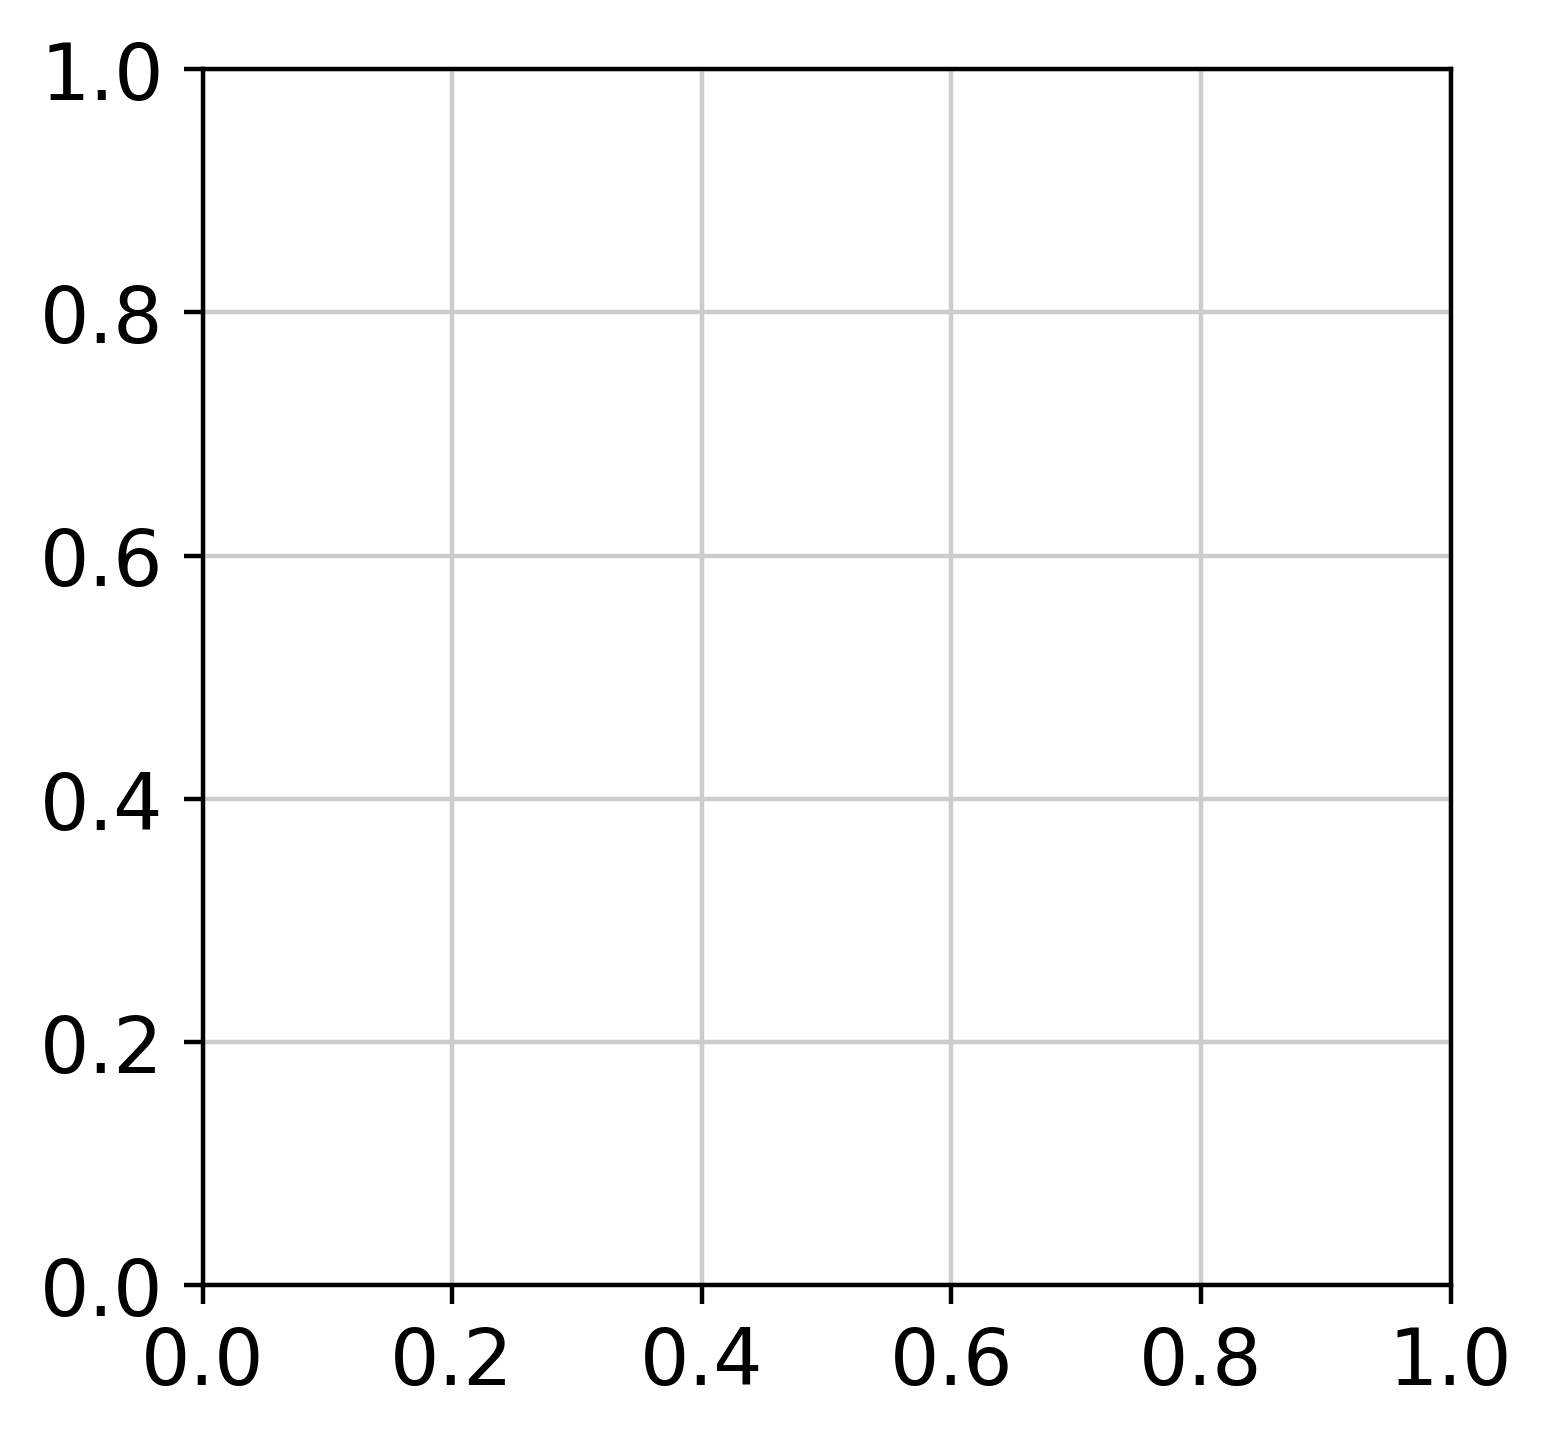

In [266]:
sc.pl.draw_graph(adata_sub,color="lepr_prediction")

In [295]:
adata_sub.var_names

Index(['1190002N15Rik', '1200007C13Rik', '1500009L16Rik', '1500015O10Rik',
       '1700086L19Rik', '1810011O10Rik', '1810041L15Rik', '2010111I01Rik',
       '2200002D01Rik', '2810001G20Rik',
       ...
       'Zfhx3', 'Zfhx4', 'Zfp36', 'Zfp36l1', 'Zfp36l2', 'Zfp503', 'Zfp618',
       'Zfp703', 'Zim1', 'Zscan26'],
      dtype='object', length=2000)

In [294]:
pd.DataFrame(adata.var_names[adata.var["highly_variable"]]).to_csv("../data/soft_prepare/variable_2000.csv")

In [300]:
adata

AnnData object with n_obs × n_vars = 272369 × 62934
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'Sample', 'Project', 'Limb.Atlas', 'Organ', 'Tissue', 'Tissue.Specific.', 'Stage', 'Gene.type', 'Treatment', 'Age', 'Age.In.Detail.', 'Machine', 'Species', 'Isolation.approach', 'Digestion', 'Enzymes', 'Bone.Forming.Methods', 'Data.Source', 'Related.Assay', 'Origin', 'nCount_RNA', 'nFeature_RNA', 'paper_label', 'coarse_label', 'scDblFinder_class', 'short_id', 'temp_cluster', 'batch', 'batch_atlas', 'size_factors', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'new_totals_log', 'anno_level_1', 'anno_level_2', 'anno_level_3', 'anno_level_4', 'anno_level_5', 'mix_level_1', 'mix_level_2', 'merge_id_level3', 'merge_id_level4', 'merge_id_level5', 'cellid', 'leiden_clusters_level_1', 'leiden_clusters_level_2', 'le